In [1]:
import sys
import os

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file 
    in the provided experiment subdirectory. The agent is created with the 
    given training and validation environments and loads its previous state.
    
    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.

    
    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")
    
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn")
    )
    
    return agent

def run_policy_agent(agent, max_steps=1000):
    """
    Run the simulation using the agent’s policy (exploitation only).
    
    Args:
        env: The environment (which must have a reset and step method).
        agent: An already-trained AgentDQN instance.
        max_steps: Maximum number of steps to run.
        
    Returns:
        opinions_over_time: Array of opinions (states) over time.
        time_points: Array of time stamps.
        rewards_over_time: Array of rewards collected at each step.
        actions_over_time: Array of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []  # New: record the actions used.
    opinions_over_time = []
    env = agent.validation_env
    
    current_time = 0.0
    # Reset environment
    state, _ = env.reset()
    opinions_over_time.append(state.copy())
    
    for step in range(max_steps):
        # Convert state to a batched tensor (batch size = 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # Use the agent in exploitation mode (epsilon=0, random_action=False)
        # The agent.select_action returns (action, beta_idx, q_value)
        action, _, _, _ = agent.select_action(state_tensor, epsilon=0.0, random_action=False)
        # action is returned as a NumPy array with shape (1, n_agents)
        action = np.squeeze(action)  # Now action has shape (n_agents,)
        actions_over_time.append(action.copy())
        
        # Apply the action in the environment.
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        
        current_time += env.tau
        state = next_state
        
        if done or truncated:
            print(f"Simulation ended at step {step}: done={done}, truncated={truncated}")
            break

    return (np.array(opinions_over_time),
            np.array(time_points),
            np.array(rewards_over_time),
            np.array(actions_over_time))

2025-05-03 22:39:41,785 - dqn - INFO - opinion_dqn.py:218 - Loaded configuration settings.
2025-05-03 22:39:42,657 - dqn - INFO - opinion_dqn.py:277 - Initialized networks and optimizer.


d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\opinion_dqn.py:305: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(training_stats_file)


2025-05-03 22:39:44,559 - dqn - INFO - opinion_dqn.py:163 - Loaded previous training status from the following files: {'replay_buffer_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May02-101004_configs\\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\\1\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May02-101004_configs\\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\\1\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May02-1

d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\opinion_dqn.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(models_load_file)


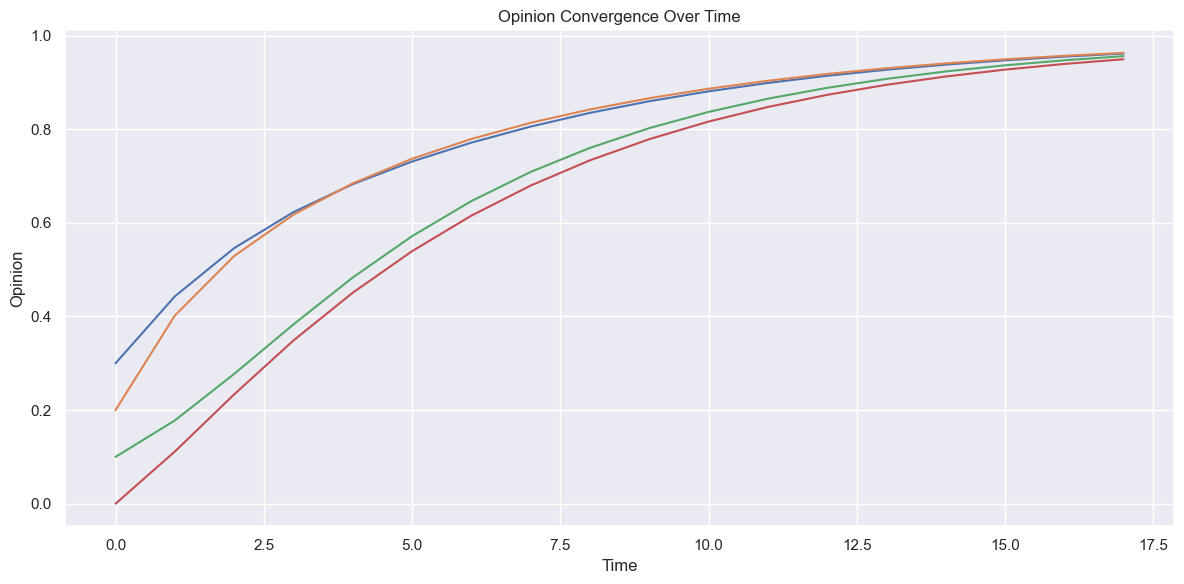

In [2]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1"

agent = instantiate_agent(exp_subdir)

max_steps = 30
states, times, rewards, actions = run_policy_agent(agent, max_steps=max_steps)

plot_opinions_over_time(states)


In [3]:
len(actions)

17

In [4]:
actions

array([[0.24753603, 0.24521978, 0.03255356, 0.07469058],
       [0.24067222, 0.20723826, 0.05372978, 0.09835975],
       [0.23063757, 0.18352443, 0.07581799, 0.11002006],
       [0.21967392, 0.17223522, 0.09330309, 0.11478783],
       [0.21044298, 0.1656808 , 0.10545979, 0.11841644],
       [0.20373029, 0.16127732, 0.11405095, 0.12094146],
       [0.198952  , 0.15797348, 0.1203663 , 0.12270824],
       [0.19541408, 0.15537348, 0.12517078, 0.12404171],
       [0.1906614 , 0.15445015, 0.12957136, 0.12531716],
       [0.18659806, 0.15384907, 0.13314666, 0.12640624],
       [0.18339172, 0.15330333, 0.13598694, 0.12731802],
       [0.1808287 , 0.1528164 , 0.13826488, 0.12809004],
       [0.176659  , 0.15216762, 0.14238854, 0.12878488],
       [0.1720813 , 0.15150583, 0.14710484, 0.12930807],
       [0.16854626, 0.15095612, 0.15082927, 0.12966838],
       [0.16575843, 0.15004781, 0.15443921, 0.1297546 ],
       [0.16356012, 0.14933337, 0.15730038, 0.12980613]], dtype=float32)

In [5]:
gamma = 0.9
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

-3.8579728641085547

In [6]:
sum(rewards)

-5.534998133081196